# 1) Data Preprocessing

In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop garbage columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels (0 and 1)
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1}) # create new column as 'b_labels'
y = df['b_labels'].values

In [11]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [12]:
# Convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [13]:
# Check word index mapping (to check the number of words in vocabulary)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique tokens are: %s' % V)

Total number of unique tokens are: 7227


In [14]:
# pad sequences (to get  N x T matrix)
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# N: number of samples and T: Number of time steps

Shape of data train tensor: (3733, 189)


In [15]:
# set the value of T to get sequence length
T = data_train.shape[1]

In [16]:
print(T)

189


In [17]:
# pad the test set
data_test = pad_sequences(sequences_test, maxlen=T)
# maxlen = T, to truncate longer sentences in test set
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


# 2) Building the Model

In [21]:

# Choose embedding dimensionality
D = 15  # this is a hyper parameter, we can choose any word vector size that we want

# Hidden state vectorsize (dimensionality)
M = 25

# Input layer
i = Input(shape=(T,))  # input layer takes in sequences of integers, so shape is T

# Embedding layer
x = Embedding(V + 1, D)(i) # This takes in sequences of integers and returns sequences of word vectors
# This will be an N * T * D array
# we want size of embedding to (V + 1) x D, because first word index starts from 1 and not 0

# LSTM layer
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer
x = Dense(1, activation='sigmoid')(x)
# it is an binary classification problem, so we are using activation function ='sigmoid'

model = Model(i, x)


In [22]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Train the model
r = model.fit(x=data_train, y=y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 7s 47ms/step - loss: 0.4563 - accuracy: 0.8575 - val_loss: 0.4019 - val_accuracy: 0.8597
Epoch 2/10
117/117 [==============================] - 6s 49ms/step - loss: 0.3763 - accuracy: 0.8690 - val_loss: 0.3697 - val_accuracy: 0.8597
Epoch 3/10
117/117 [==============================] - 5s 46ms/step - loss: 0.2684 - accuracy: 0.8880 - val_loss: 0.1722 - val_accuracy: 0.9434
Epoch 4/10
117/117 [==============================] - 5s 44ms/step - loss: 0.0829 - accuracy: 0.9853 - val_loss: 0.0733 - val_accuracy: 0.9821
Epoch 5/10
117/117 [==============================] - 5s 44ms/step - loss: 0.0397 - accuracy: 0.9925 - val_loss: 0.0605 - val_accuracy: 0.9853
Epoch 6/10
117/117 [==============================] - 5s 44ms/step - loss: 0.0243 - accuracy: 0.9960 - val_loss: 0.0504 - val_accuracy: 0.9859
Epoch 7/10
117/117 [==============================] - 5s 45ms/step - loss: 0.0146 - accuracy: 0.9987 - val_loss: 0.0491 - val_accuracy: 0.9886

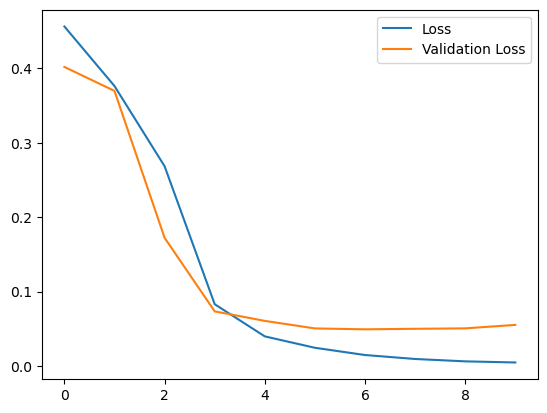

In [24]:
# Loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

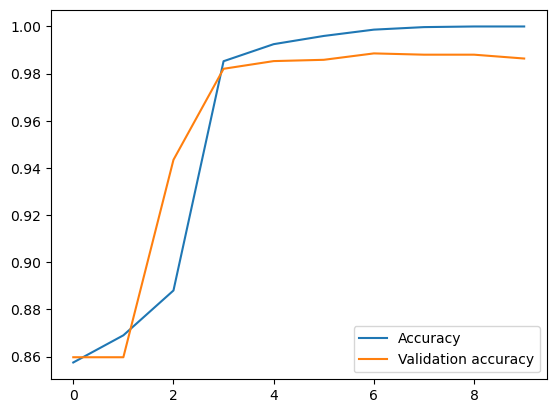

In [25]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [47]:
# New text to classify
new_text = "you won lottery!"

# Preprocess the text
new_sequence = tokenizer.texts_to_sequences([new_text])

# pad the test set
d = pad_sequences(new_sequence, maxlen=T)
# maxlen = T, to truncate longer sentences in test set
print('Shape of data test tensor:', d.shape)

Shape of data test tensor: (1, 189)


In [48]:
new_sequence

[[3, 208]]

In [49]:
# Predict using the model
prediction = model.predict(d)
prediction


1/1 [==============================] - 0s 30ms/step


array([[0.11559385]], dtype=float32)

In [51]:
# Interpret the prediction
if prediction > 0.5:
    print("The text is likely spam.")
else:
    print("The text is likely not spam.")


The text is likely not spam.
